checkpoint: tliu/helmholtz_isotropic_1.0/model-3vweeuk1:best
kept model-3vweeuk1:v17, ['best', 'latest']


wandb: Downloading large artifact model-3vweeuk1:best, 192.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 4,
 'num_in_channels': 1,
 'num_out_channels': 2}
checkpoint: tliu/helmholtz_isotropic_1.0/model-5t7k78me:best
kept model-5t7k78me:v14, ['best', 'latest']


wandb: Downloading large artifact model-5t7k78me:best, 384.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 8,
 'num_in_channels': 1,
 'num_out_channels': 2}
checkpoint: tliu/helmholtz_isotropic_1.0/model-n3fcxet4:best
kept model-n3fcxet4:v17, ['latest', 'best']


wandb: Downloading large artifact model-n3fcxet4:best, 88.95MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'channel_reduction_factor': 2,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 2}
checkpoint: tliu/helmholtz_isotropic_1.0/model-2rwsput0:best
kept model-2rwsput0:v15, ['latest', 'best']


wandb: Downloading large artifact model-2rwsput0:best, 355.33MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6


model hparams:
{'channel_reduction_factor': 1,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 2}
checkpoint: tliu/helmholtz_isotropic_1.5/model-o0nu3wfx:best
kept model-o0nu3wfx:v18, ['best', 'latest']


wandb: Downloading large artifact model-o0nu3wfx:best, 192.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 4,
 'num_in_channels': 1,
 'num_out_channels': 2}
checkpoint: tliu/helmholtz_isotropic_1.5/model-nokxpxbp:best
kept model-nokxpxbp:v18, ['latest', 'best']


wandb: Downloading large artifact model-nokxpxbp:best, 384.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 8,
 'num_in_channels': 1,
 'num_out_channels': 2}
checkpoint: tliu/helmholtz_isotropic_1.5/model-g87y9gqj:best
kept model-g87y9gqj:v17, ['latest', 'best']


wandb: Downloading large artifact model-g87y9gqj:best, 88.95MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'channel_reduction_factor': 2,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 2}
checkpoint: tliu/helmholtz_isotropic_1.5/model-mth5y8ke:best
kept model-mth5y8ke:v18, ['best', 'latest']


wandb: Downloading large artifact model-mth5y8ke:best, 355.33MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6


model hparams:
{'channel_reduction_factor': 1,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 2}
checkpoint: tliu/helmholtz_isotropic_2.0/model-vgs68bq0:best
kept model-vgs68bq0:v17, ['latest', 'best']


wandb: Downloading large artifact model-vgs68bq0:best, 192.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 4,
 'num_in_channels': 1,
 'num_out_channels': 2}
checkpoint: tliu/helmholtz_isotropic_2.0/model-nnv8ytdd:best
kept model-nnv8ytdd:v16, ['latest', 'best']


wandb: Downloading large artifact model-nnv8ytdd:best, 384.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 8,
 'num_in_channels': 1,
 'num_out_channels': 2}
checkpoint: tliu/helmholtz_isotropic_2.0/model-kpebl7z1:best
kept model-kpebl7z1:v17, ['latest', 'best']


wandb: Downloading large artifact model-kpebl7z1:best, 88.95MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'channel_reduction_factor': 2,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 2}
checkpoint: tliu/helmholtz_isotropic_2.0/model-6385en90:best
kept model-6385en90:v19, ['best', 'latest']


wandb: Downloading large artifact model-6385en90:best, 355.33MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6


model hparams:
{'channel_reduction_factor': 1,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 2}
checkpoint: tliu/helmholtz_isotropic_4.0/model-sa3g27jn:best
kept model-sa3g27jn:v18, ['best', 'latest']


wandb: Downloading large artifact model-sa3g27jn:best, 192.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 4,
 'num_in_channels': 1,
 'num_out_channels': 2}
checkpoint: tliu/helmholtz_isotropic_4.0/model-2d0ng0xa:best
kept model-2d0ng0xa:v18, ['latest', 'best']


wandb: Downloading large artifact model-2d0ng0xa:best, 384.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 8,
 'num_in_channels': 1,
 'num_out_channels': 2}
checkpoint: tliu/helmholtz_isotropic_4.0/model-t7m6ehyr:best
kept model-t7m6ehyr:v18, ['best', 'latest']


wandb: Downloading large artifact model-t7m6ehyr:best, 88.95MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'channel_reduction_factor': 2,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 2}
checkpoint: tliu/helmholtz_isotropic_4.0/model-zntpz4in:best
kept model-zntpz4in:v19, ['best', 'latest']


wandb: Downloading large artifact model-zntpz4in:best, 355.33MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6


model hparams:
{'channel_reduction_factor': 1,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 2}
checkpoint: tliu/helmholtz_anisotropic_1.0/model-4iy0kedw:best
kept model-4iy0kedw:v17, ['latest', 'best']


wandb: Downloading large artifact model-4iy0kedw:best, 192.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 4,
 'num_in_channels': 1,
 'num_out_channels': 2}
checkpoint: tliu/helmholtz_anisotropic_1.0/model-j20sluc2:best
kept model-j20sluc2:v16, ['latest', 'best']


wandb: Downloading large artifact model-j20sluc2:best, 384.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 8,
 'num_in_channels': 1,
 'num_out_channels': 2}
checkpoint: tliu/helmholtz_anisotropic_1.0/model-ezw6zw6l:best
kept model-ezw6zw6l:v13, ['latest', 'best']


wandb: Downloading large artifact model-ezw6zw6l:best, 88.95MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0


model hparams:
{'channel_reduction_factor': 2,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 2}
checkpoint: tliu/helmholtz_anisotropic_1.0/model-6iw6nxc0:best
kept model-6iw6nxc0:v15, ['best', 'latest']


wandb: Downloading large artifact model-6iw6nxc0:best, 355.33MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6


model hparams:
{'channel_reduction_factor': 1,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 2}
checkpoint: tliu/helmholtz_anisotropic_1.5/model-j4ak3set:best
kept model-j4ak3set:v19, ['best', 'latest']


wandb: Downloading large artifact model-j4ak3set:best, 192.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 4,
 'num_in_channels': 1,
 'num_out_channels': 2}
checkpoint: tliu/helmholtz_anisotropic_1.5/model-ndah54gh:best
kept model-ndah54gh:v18, ['latest', 'best']


wandb: Downloading large artifact model-ndah54gh:best, 384.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 8,
 'num_in_channels': 1,
 'num_out_channels': 2}
checkpoint: tliu/helmholtz_anisotropic_1.5/model-sdyih6sz:best
kept model-sdyih6sz:v13, ['best', 'latest']


wandb: Downloading large artifact model-sdyih6sz:best, 88.95MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7


model hparams:
{'channel_reduction_factor': 2,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 2}
checkpoint: tliu/helmholtz_anisotropic_1.5/model-bezkce47:best
kept model-bezkce47:v17, ['best', 'latest']


wandb: Downloading large artifact model-bezkce47:best, 355.33MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6


model hparams:
{'channel_reduction_factor': 1,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 2}
checkpoint: tliu/helmholtz_anisotropic_2.0/model-pixokxrh:best
kept model-pixokxrh:v19, ['best', 'latest']


wandb: Downloading large artifact model-pixokxrh:best, 192.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 4,
 'num_in_channels': 1,
 'num_out_channels': 2}
checkpoint: tliu/helmholtz_anisotropic_2.0/model-dlepfaaa:best
kept model-dlepfaaa:v18, ['best', 'latest']


wandb: Downloading large artifact model-dlepfaaa:best, 384.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 8,
 'num_in_channels': 1,
 'num_out_channels': 2}
checkpoint: tliu/helmholtz_anisotropic_2.0/model-suiehlsq:best
kept model-suiehlsq:v13, ['latest', 'best']


wandb: Downloading large artifact model-suiehlsq:best, 88.95MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'channel_reduction_factor': 2,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 2}
checkpoint: tliu/helmholtz_anisotropic_2.0/model-mc4et2e9:best
kept model-mc4et2e9:v19, ['best', 'latest']


wandb: Downloading large artifact model-mc4et2e9:best, 355.33MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6


model hparams:
{'channel_reduction_factor': 1,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 2}
checkpoint: tliu/helmholtz_anisotropic_4.0/model-0h2fqxd4:best
kept model-0h2fqxd4:v19, ['best', 'latest']


wandb: Downloading large artifact model-0h2fqxd4:best, 192.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 4,
 'num_in_channels': 1,
 'num_out_channels': 2}
checkpoint: tliu/helmholtz_anisotropic_4.0/model-psl75p55:best
kept model-psl75p55:v19, ['best', 'latest']


wandb: Downloading large artifact model-psl75p55:best, 384.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 8,
 'num_in_channels': 1,
 'num_out_channels': 2}
checkpoint: tliu/helmholtz_anisotropic_4.0/model-glyjbdea:best
kept model-glyjbdea:v16, ['latest', 'best']


wandb: Downloading large artifact model-glyjbdea:best, 88.95MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'channel_reduction_factor': 2,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 2}
checkpoint: tliu/helmholtz_anisotropic_4.0/model-5m4ee7ds:best
kept model-5m4ee7ds:v19, ['latest', 'best']


wandb: Downloading large artifact model-5m4ee7ds:best, 355.33MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6


model hparams:
{'channel_reduction_factor': 1,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 2}


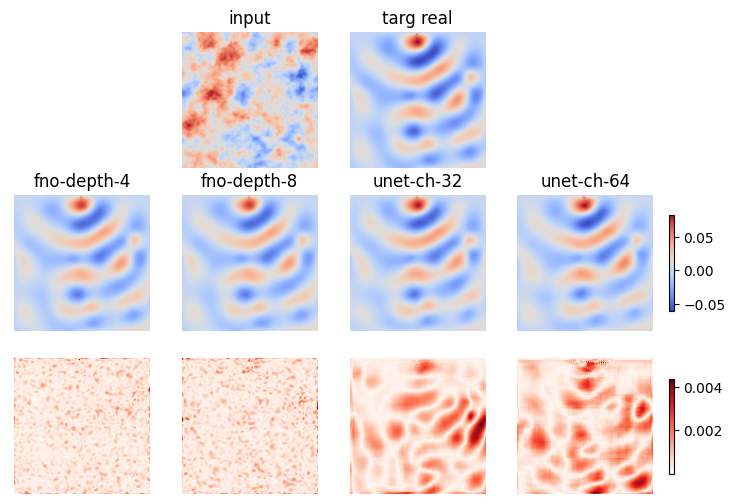

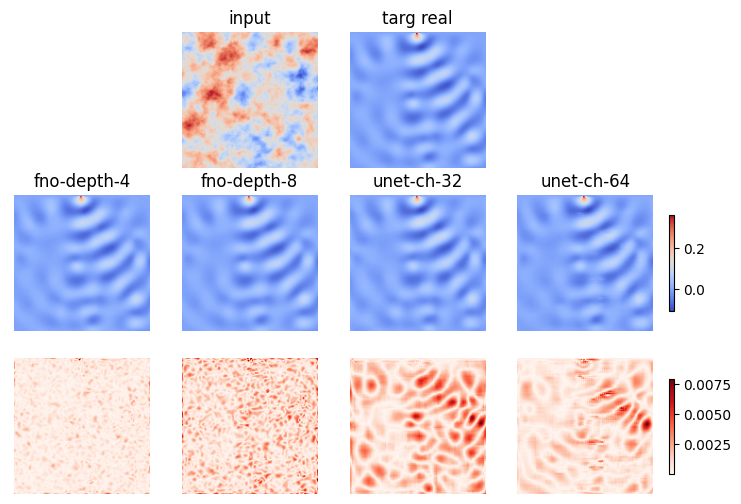

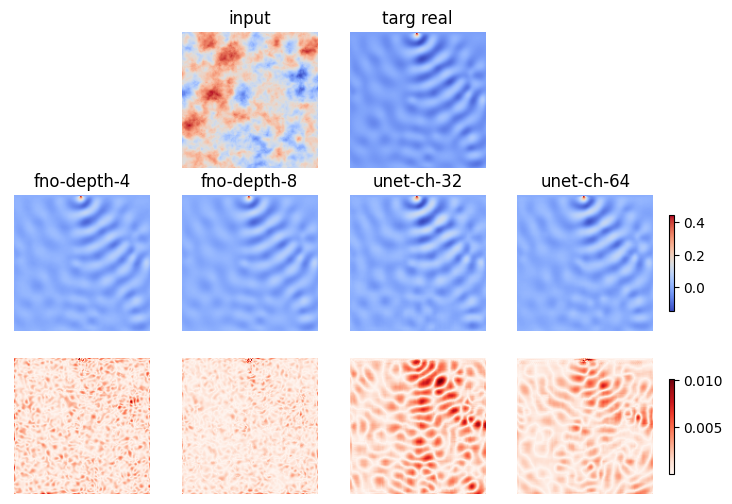

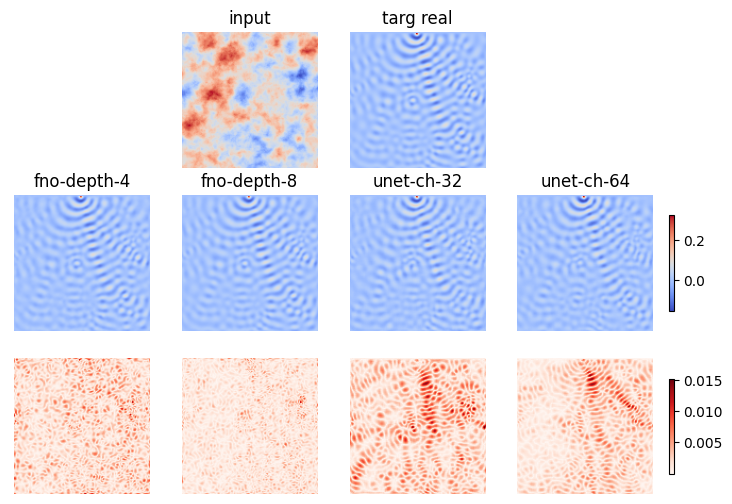

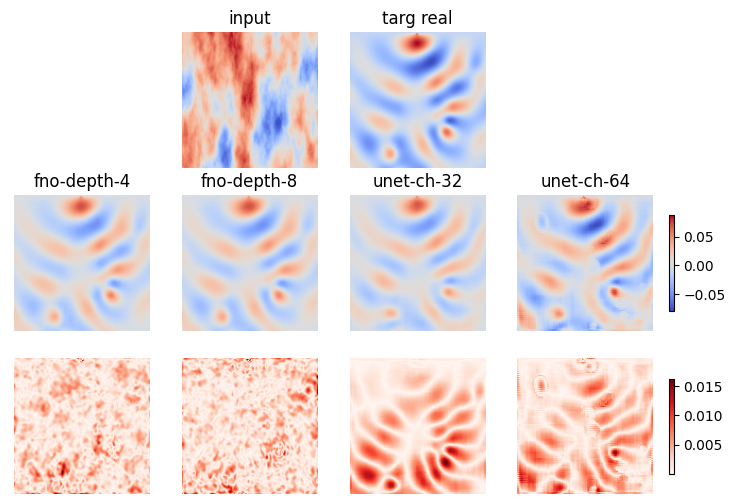

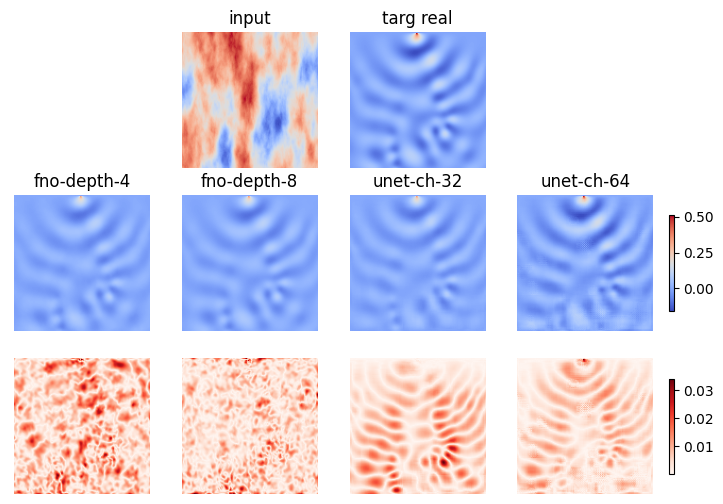

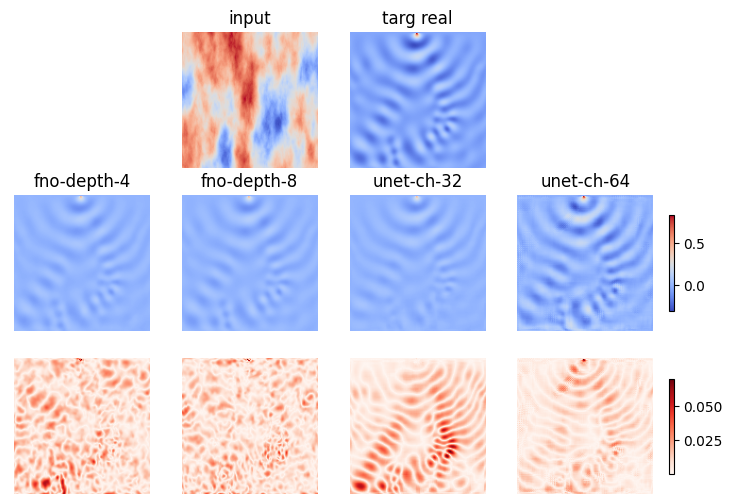

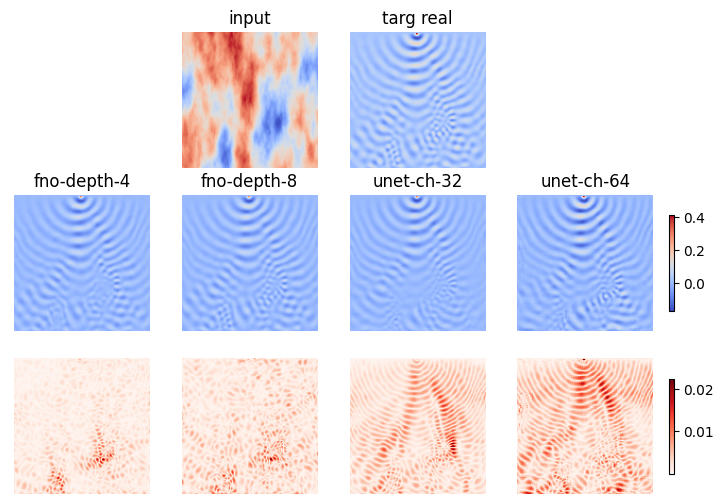

In [1]:
""" Evaluate all models on the time-harmonic datasets"""
import pprint
from pathlib import Path
import wandb
import matplotlib.pyplot as plt
import ml_collections
from pytorch_lightning.loggers import WandbLogger
import os
# from matplotlib import colors
import torch
from wavebench.dataloaders.helmholtz_loader import get_dataloaders_helmholtz
import numpy as np

from wavebench import wavebench_figure_path
from wavebench.nn.pl_model_wrapper import LitModel
from wavebench import wavebench_checkpoint_path
from wavebench.plot_utils import plot_images, remove_frame



all_models = [
  {
    "tag": 'fno-depth-4',
    "config.model_config/model_name": 'fno',
    "config.model_config/num_hidden_layers": 4
  },
  {
    "tag": 'fno-depth-8',
    "config.model_config/model_name": 'fno',
    "config.model_config/num_hidden_layers": 8
  },
  {
    "tag": 'unet-ch-32',
    "config.model_config/model_name": 'unet',
    "config.model_config/channel_reduction_factor": 2
  },
  {
    "tag": 'unet-ch-64',
    "config.model_config/model_name": 'unet',
    "config.model_config/channel_reduction_factor": 1
  },

              ]


# Initialize the W&B API client
api = wandb.Api()


pp = pprint.PrettyPrinter(depth=6)
device = 'cpu'

eval_config = ml_collections.ConfigDict()


eval_config.visualize_real_prediction = True

# problem setting: can be 'isotropic' or 'anisotropic'
# for eval_config.kernel_type in ['isotropic', 'anisotropic']:
for eval_config.kernel_type in ['anisotropic']:

  # frequency: can be in [1.0, 1.5, 2.0, 4.0]
  for eval_config.frequency in [4.0]:
  # for eval_config.frequency in [1.0, 1.5, 2.0, 4.0]:
    # save_path = f"{wavebench_figure_path}/time_harmonic/model_out_{eval_config.kernel_type}_{eval_config.frequency}"
    save_path = f"{wavebench_figure_path}/time_harmonic/"

    if not os.path.exists(save_path):
      os.makedirs(save_path)

    test_loader = get_dataloaders_helmholtz(
      eval_config.kernel_type,
      eval_config.frequency)['test']
    model_dict = {}

    for model_filters in all_models:
      _model_filters = model_filters.copy()

      model_tag = _model_filters.pop('tag')

      project = f'helmholtz_{eval_config.kernel_type}_{eval_config.frequency}'
      runs = api.runs(
        path=f"tliu/{project}",
        filters=_model_filters)

      # make sure that there is a unique model that satisfies the filters
      assert len(runs) == 1

      run_id = runs[0].id

      checkpoint_reference = f"tliu/{project}/model-{run_id}:best"
      print(f'checkpoint: {checkpoint_reference}')

      # delete all the checkpoints that do not have the aliases such as 'best
      artifact_versions = api.artifact_versions(
        name=f'{project}/model-{run_id}', type_name='model')

      for v in artifact_versions:
        if len(v.aliases) == 0:
          v.delete()
          print(f'deleted {v.name}')
        else:
          print(f'kept {v.name}, {v.aliases}')

      artifact_dir = WandbLogger.download_artifact(
        artifact=checkpoint_reference,
        save_dir=wavebench_checkpoint_path)

      # load checkpoint
      model = LitModel.load_from_checkpoint(
        Path(artifact_dir) / "model.ckpt").to(device)

      print('model hparams:')
      pp.pprint(model.hparams.model_config)

      model_dict[model_tag] = model

    sample_input, sample_target = next(iter(test_loader))


    # plot the predictions
    pred_dict_real = {}
    pred_dict_img = {}
    pred_diff_dict_real = {}
    pred_diff_dict_img = {}

    for tag, model in model_dict.items():
      pred = model(
        sample_input.to(device)).detach().cpu().squeeze()
      pred_dict_real[tag] = pred.squeeze()[0]
      pred_dict_img[tag] = pred.squeeze()[1]
      pred_diff_dict_real[tag] = ((
        pred.squeeze()[0] - sample_target.squeeze()[0]).abs()\
          / torch.norm(sample_target.squeeze(), p=2))
      pred_diff_dict_img[tag] = ((
        pred.squeeze()[1] - sample_target.squeeze()[1]).abs()\
          / torch.norm(sample_target.squeeze(), p=2))

    if eval_config.visualize_real_prediction:
      pred_dict = pred_dict_real
      pred_diff_dict = pred_diff_dict_real
      sample_target_channel = sample_target.squeeze()[0]
    else:
      pred_dict = pred_dict_img
      pred_diff_dict = pred_diff_dict_img
      sample_target_channel = sample_target.squeeze()[1]

    fig = plt.figure()
    fig.set_size_inches(10, 6)
    ax = fig.subplots(3, 4)
    im = np.empty(ax.shape, dtype=object)

    # First row: plot the input and target
    im[0,1] = ax[0,1].imshow(sample_input.squeeze(), cmap='coolwarm')
    im[0,2] = ax[0,2].imshow(sample_target_channel, cmap='coolwarm')
    ax[0,1].set_title('input')
    if eval_config.visualize_real_prediction:
      ax[0,2].set_title('targ real')
    else:
      ax[0,2].set_title('targ img')
    cb = fig.colorbar(im[0, 1], ax=ax[0, :], pad=0.02, shrink=0.7)
    cb.remove()

    # Second row: plot the predictions
    vrange_ = [min((x.min() for x in pred_dict.values() )), max(x.max() for x in pred_dict.values())]

    for i, model_tag in enumerate(pred_dict.keys()):
      im[1,i] = ax[1,i].imshow(
        pred_dict[model_tag], cmap='coolwarm', vmin = vrange_[0], vmax = vrange_[1])
      ax[1,i].set_title(model_tag)
    fig.colorbar(im[1, -1], ax=ax[1, :], pad=0.02, shrink=0.7)

    # Third row: plot the prediction differences
    vrange_ = [min((x.min() for x in pred_diff_dict.values() )), max(x.max() for x in pred_diff_dict.values())]

    for i, model_tag in enumerate(pred_diff_dict.keys()):
      im[2,i] = ax[2,i].imshow(
        pred_diff_dict[model_tag], cmap='Reds',
        )
    fig.colorbar(im[2, -1], ax=ax[2, :], pad=0.02, shrink=0.7)
    [remove_frame(ax_) for ax_ in ax.flatten()]
    plt.savefig(
      f"{save_path}/model_out_{eval_config.kernel_type}_{eval_config.frequency}.pdf",
      format="pdf", bbox_inches="tight")



In [2]:
8/6

1.3333333333333333